In [1]:
!type python
from platform import python_version
import tensorflow as tf
print(python_version())
tf.__version__

python is /home/swyoo/anaconda3/envs/ts20/bin/python
3.7.5


'2.0.0'

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os, sys
import matplotlib.pyplot as plt

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# GPU 메모리 제한하기
MEMORY_LIMIT_CONFIG = [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)]
print(MEMORY_LIMIT_CONFIG)
tf.config.experimental.set_virtual_device_configuration(gpus[0], MEMORY_LIMIT_CONFIG)

[VirtualDeviceConfiguration(memory_limit=2048)]


In [4]:
# helper function for print
def print_progress(epoch, max_epoch, step, max_step, loss, etc):
    """ print progressive states """
    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r Train Phase - epoch: {0:}/{1:} |step: {2:}/{3:} |loss: {4:.3f} |etc: {5:}".format(epoch, max_epoch, step, max_step, loss, etc)
    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush() 

# Classfication of Iris 

이번 튜토리얼에서는 오직 3가지 품종을 기준으로 분류할 것임.  
`Iris setosa, Iris virginica,Iris versicolor`  
[Dataset](https://www.wikiwand.com/en/Iris_flower_data_set) :꽃받침과 꽃잎의 길이와 폭이 측정된 120개의 붓꽃 데이터

**Parsing dataset**

In [5]:
# tf.keras.utils.get_file 함수를 사용하여 데이터셋을 다운로드
train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"
train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)
print("데이터셋이 복사된 위치: {}".format(train_dataset_fp))

데이터셋이 복사된 위치: /home/swyoo/.keras/datasets/iris_training.csv


**Exploration**  
1. 첫 번째 줄은 다음과 같은 정보를 포함하고 있는 헤더(header)입니다.  
    총 120개의 샘플이 있으며, 각 샘플들은 4개의 특성(feature), 3개의 레이블(label)을 가지고 있습니다.  
2. 후속행은 데이터 레코드입니다. 한 줄당 한 개의 샘플 입니다.  
    * 처음 4개의 필드는 특성 입니다.: 이것들은 샘플의 특징을 나타냅니다. 이 필드들는 붓꽃의 측정값을 부동소수점으로 나타냅니다.  
    * 마지막 컬럼(column)은 레이블(label) 입니다.: 레이블은 예측하고자 하는 값을 나타냅니다. 이 데이터셋에서는 꽃의 이름과 관련된 정수값 0, 1, 2를 나타냅니다.  

In [6]:
# 총 120개의 샘플이 있으며, 각 샘플들은 4개의 특성(feature), 3개의 레이블(label)
!head -n3 {train_dataset_fp}

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1


In [7]:
# CSV 파일안에서 컬럼의 순서
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
feature_names = column_names[:-1]
label_name = column_names[-1]
print("propery: {}".format(feature_names))
print("label: {}".format(label_name))
# mapping class labels 
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

propery: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
label: species


**Generate tf.data.Dataset**

데이터셋이 CSV 파일이므로, 적절한 형태로 데이터를 구분하기 위해 `make_csv_dataset` 함수를 사용  
`make_csv_dataset` 함수는 `(features, label)` 쌍으로 구성된 `tf.data.Dataset`을 반환합니다.   
`features`는 딕셔너리 객체인: `{'feature_name': value}`로 주어집니다. 이 데이터셋은 반복가능합니다.

In [8]:
BATCH_SIZE = 32
EPOCHS = 1

train_dataset = tf.data.experimental.make_csv_dataset(train_dataset_fp,
                                                      BATCH_SIZE,
                                                      column_names=column_names,
                                                      label_name=label_name,
                                                      num_epochs=EPOCHS)

Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.


In [9]:
# feature 들은 dictionary로 되어있는 tensor들이므로 dictionary를 묶어주는 작업 필요
features, labels = next(iter(train_dataset))
print(features)

OrderedDict([('sepal_length', <tf.Tensor: id=68, shape=(32,), dtype=float32, numpy=
array([5.7, 6.9, 6.8, 6.3, 6. , 5. , 6.5, 6.7, 6.4, 5.8, 5.6, 6.1, 4.9,
       6.2, 7.7, 4.9, 6.1, 7.2, 7.4, 4.4, 5.8, 5.4, 4.9, 5. , 5.6, 5.7,
       5.7, 7.2, 7.2, 5. , 5.8, 6.8], dtype=float32)>), ('sepal_width', <tf.Tensor: id=69, shape=(32,), dtype=float32, numpy=
array([3.8, 3.1, 3. , 3.3, 2.9, 3.6, 3. , 3.3, 2.8, 2.7, 2.7, 2.6, 3.1,
       3.4, 2.6, 2.4, 2.8, 3.6, 2.8, 3.2, 2.7, 3.9, 3.1, 3.5, 2.9, 4.4,
       3. , 3. , 3.2, 3.4, 2.8, 2.8], dtype=float32)>), ('petal_length', <tf.Tensor: id=66, shape=(32,), dtype=float32, numpy=
array([1.7, 4.9, 5.5, 4.7, 4.5, 1.4, 5.2, 5.7, 5.6, 5.1, 4.2, 5.6, 1.5,
       5.4, 6.9, 3.3, 4. , 6.1, 6.1, 1.3, 5.1, 1.3, 1.5, 1.6, 3.6, 1.5,
       4.2, 5.8, 6. , 1.5, 5.1, 4.8], dtype=float32)>), ('petal_width', <tf.Tensor: id=67, shape=(32,), dtype=float32, numpy=
array([0.3, 1.5, 2.1, 1.6, 1.5, 0.2, 2. , 2.1, 2.2, 1.9, 1.3, 1.4, 0.1,
       2.3, 2.3, 1. , 1.3, 2.5, 1

In [10]:
print(labels)

tf.Tensor([0 1 2 1 1 0 2 2 2 2 1 2 0 2 2 1 1 2 2 0 2 0 0 0 1 0 1 2 2 0 2 1], shape=(32,), dtype=int32)


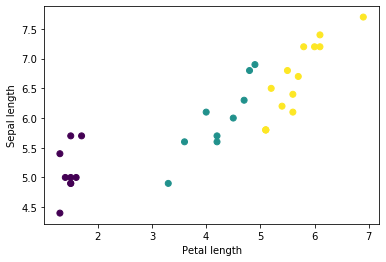

In [11]:
# visualization
plt.scatter(features['petal_length'],
            features['sepal_length'],
            c=labels,
            cmap='viridis')

plt.xlabel("Petal length")
plt.ylabel("Sepal length")
plt.show()

In [12]:
train_dataset.element_spec

(OrderedDict([('sepal_length',
               TensorSpec(shape=(None,), dtype=tf.float32, name=None)),
              ('sepal_width',
               TensorSpec(shape=(None,), dtype=tf.float32, name=None)),
              ('petal_length',
               TensorSpec(shape=(None,), dtype=tf.float32, name=None)),
              ('petal_width',
               TensorSpec(shape=(None,), dtype=tf.float32, name=None))]),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [13]:
# feature 들은 dictionary로 되어있는 tensor들이므로 dictionary를 minibatch 별로 묶어주는 작업 필요
# map 함수를 이용한다.
def pack_features_vector(features, labels):
    """ 미니배치 크기의 특성들을 묶는함수."""
    features = tf.stack(list(features.values()), axis=1)
    return features, labels

train_dataset = train_dataset.map(map_func=pack_features_vector)

In [14]:
# check 
train_dataset.element_spec

(TensorSpec(shape=(None, 4), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [15]:
# check 
features, labels = next(iter(train_dataset))
features.shape

TensorShape([32, 4])

[detail tutorial for creating customized model](https://www.tensorflow.org/guide/keras/custom_layers_and_models?hl=ko)  
build 함수가 꼭 있어야한다.  
추정하기로는 Dense 함수는 내부에 build함수가 구현되어있지 않아 lazy 한 weight생성을 하지 않는것 같다.

In [16]:
tf.keras.Model.build

<function tensorflow.python.keras.engine.network.Network.build(self, input_shape)>

이 3가지 표현 모두 동일하게 작동한다.
```python
self.D1 = tf.keras.layers.Dense(units=10, activation=tf.nn.relu, input_shape=(None, input_shape[-1]))
self.D1 = tf.keras.layers.Dense(units=10, activation=tf.nn.relu, input_shape=(input_shape[-1], ))
self.D1 = tf.keras.layers.Dense(units=10, activation=tf.nn.relu)
```

In [17]:
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__(name='swyoo')
        
    def build(self, input_shape):
        """ when call fucntion is called, all weights will be created. 
            Also, input_shape can be input_tensor.shape automatically! 
            so, input_shape = input_tensor.shape """
        # self.D1 = tf.keras.layers.Dense(units=10, activation=tf.nn.relu, input_shape=(None, input_shape[-1]))
        # self.D1 = tf.keras.layers.Dense(units=10, activation=tf.nn.relu, input_shape=(input_shape[-1], ))
        # automatically catch the input's shape
        self.D1 = tf.keras.layers.Dense(units=10, activation=tf.nn.relu)
        self.D2 = tf.keras.layers.Dense(10, activation=tf.nn.relu)
        self.D3 = tf.keras.layers.Dense(3)
        
    def call(self, input_tensor):
        """ 
        Args: 
            input_tensor.shpae=[examples, 4] 
        Returns: output.shape=[eaxmples, 3]
        """
        x = self.D1(input_tensor)
        x = self.D2(x)
        x = self.D3(x)
        return x
    
model = Model()

# model = tf.keras.Sequential([tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # 입력의 형태가 필요합니다.
#                              tf.keras.layers.Dense(10, activation=tf.nn.relu),
#                              tf.keras.layers.Dense(3)])

In [18]:
predictions = model(features)
predictions[:2]

<tf.Tensor: id=200, shape=(2, 3), dtype=float32, numpy=
array([[-1.9688914 ,  1.7115858 , -0.36923853],
       [-2.6221304 ,  2.2794561 , -0.49174452]], dtype=float32)>

**Train Phase**

`SparseCategoricalCrossentropy(from_logits=True)` 의미하는 것은
1. `Sparse*`이면 y_true는 label index를 준다.
2. `from_logits`이면 y_pred는 logits값이고 내부에서 activation 적용된다.
3. `Categorical`이면 label class가 binary가 아닌 muti-class 상황이다.  

b = `BATCH_SIZE`, i = a index of an example
$$
loss = \frac{1}{b}\sum^b_i{\mathbf{Y_i}\odot log(\mathbf{\hat{Y_i}})}
$$

In [19]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
def loss_function(model, X, Y):
    """ del.call 함수에 의한 logit을 구하여 loss를 계산한다.
    Args:
        X: (minibatch, 4)
        Y: (minibatch, )
    Params:
        logits: (minibatch, 3)
    """
    logits = model(X)
    return loss_object(y_true=Y, y_pred=logits)

l = loss_function(model, features, labels)
print("test for loss: {}".format(l)) # inital loss

test for loss: 2.25604248046875


In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

In [21]:
def train_step(model, x, y, optimizer):
    ##################################################################################
    # TODO: compute gradients for minibatch and apply them
    ##################################################################################
    with tf.GradientTape() as T:
        loss_value = loss_function(model, x, y)
    grads = T.gradient(target=loss_value, sources=model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    ##################################################################################
    return loss_value

In [22]:
EPOCHS = 200
NUM_EXAMPLES = 150
STEPS = NUM_EXAMPLES//BATCH_SIZE

# 도식화를 위해 결과를 저장합니다.
train_loss_results = []
train_accuracy_results = []

for e in range(EPOCHS):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    # 훈련 루프 - 32개의 배치를 사용합니다.
    for s, minibatch in enumerate(train_dataset):
        x, y = minibatch
        ##################################################################################
        # train_step: compute gradients for minibatch and apply them
        ##################################################################################
        loss_value = train_step(model, x, y, optimizer=optimizer)
        ##################################################################################
        # 진행 상황을 추적합니다.
        epoch_loss_avg(loss_value)  # 현재 배치 손실을 추가합니다.
        # 예측된 레이블과 실제 레이블 비교합니다.
        epoch_accuracy(y, model(x))
        print_progress(epoch=e+1, max_epoch=EPOCHS, step=s+1, max_step=STEPS, 
                       loss=epoch_loss_avg.result(), 
                       etc=epoch_accuracy.result())

    # epoch 종료
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

 Train Phase - epoch: 200/200 |step: 4/4 |loss: 0.055 |etc: 0.9833333492279053

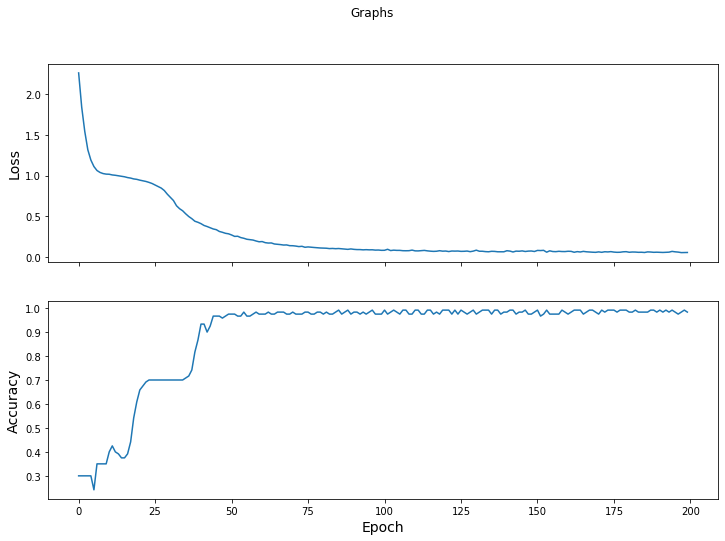

In [23]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Graphs')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

**Test Phase**

In [24]:
test_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"
test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url), origin=test_url)
print(test_fp)

/home/swyoo/.keras/datasets/iris_test.csv


In [25]:
test_dataset = tf.data.experimental.make_csv_dataset(test_fp, BATCH_SIZE, column_names=column_names, 
                                                     label_name='species', num_epochs=1, shuffle=False)
test_dataset = test_dataset.map(pack_features_vector)

In [26]:
test_accuracy = tf.keras.metrics.Accuracy()

for (x, y) in test_dataset:
    logits = model(x)
    prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
    test_accuracy(prediction, y)

print("Accuracy for test dataset {:.3%}".format(test_accuracy.result()))

Accuracy for test dataset 93.333%
